In [15]:
import numpy as np
import pandas as pd

In [16]:
p_col = 'prestas0'
t_col = 'tre200s0'

p_klo = 'PressureKlotenData/order_113889_data.txt'
t_klo = 'TemperatureKlotenData/order_113890_data.txt'
p_bas = 'PressureBinningenData/order_113893_data.txt'
t_bas = 'TemperatureBinningenData/order_113892_data.txt'

In [27]:
# read data
p_dtype = {'stn': str, 'time': int, p_col: float}
t_dtype = {'stn': str, 'time': int, t_col: float}
null_equivalent = ['-']

p_klo_df = pd.read_csv(p_klo, sep=';', dtype=p_dtype, na_values=null_equivalent)
t_klo_df = pd.read_csv(t_klo, sep=';', dtype=t_dtype, na_values=null_equivalent)
p_bas_df = pd.read_csv(p_bas, sep=';', dtype=p_dtype, na_values=null_equivalent)
t_bas_df = pd.read_csv(t_bas, sep=';', dtype=t_dtype, na_values=null_equivalent)

# concatenate dataframes for pressure and dataframes for temperature
p_df = pd.concat([p_klo_df, p_bas_df])
t_df = pd.concat([t_klo_df, t_bas_df])

# join dataframes on time and station
df = pd.merge(p_df, t_df, on=['time', 'stn'])

# drop rows with missing values and reset index
df = df.dropna()
df = df.reset_index(drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3530746 entries, 0 to 3530745
Data columns (total 4 columns):
 #   Column    Dtype  
---  ------    -----  
 0   stn       object 
 1   time      int64  
 2   prestas0  float64
 3   tre200s0  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 107.7+ MB


In [28]:
df.head()

,stn,time,prestas0,tre200s0
0,KLO,199001010000,969.2,-3.5
1,KLO,199001010010,969.1,-3.4
2,KLO,199001010020,969.1,-3.6
3,KLO,199001010030,969.1,-3.6
4,KLO,199001010040,969.1,-3.7


In [29]:
df.tail()

,stn,time,prestas0,tre200s0
3530741,BAS,202308230350,982.6,20.5
3530742,BAS,202308230400,982.6,20.6
3530743,BAS,202308230410,982.6,20.9
3530744,BAS,202308230420,982.5,20.9
3530745,BAS,202308230430,982.5,20.6


In [36]:
p_sorted_df = df.sort_values(by=[p_col, t_col, 'time', 'stn'])
p_sorted_df.head()

,stn,time,prestas0,tre200s0
524310,KLO,199912280250,927.4,0.3
524311,KLO,199912280300,927.4,0.5
524306,KLO,199912280210,927.7,0.5
524312,KLO,199912280310,927.7,0.5
524308,KLO,199912280230,927.8,0.1


In [37]:
t_sorted_df = df.sort_values(by=[t_col, p_col, 'time', 'stn'])
t_sorted_df.head()

,stn,time,prestas0,tre200s0
1160907,KLO,201202040140,979.1,-20.2
1160916,KLO,201202040310,978.6,-20.0
1160918,KLO,201202040330,978.7,-19.7
1160914,KLO,201202040250,978.6,-19.6
201705,KLO,199311031630,961.0,-19.4


In [55]:
# Extract the tre200s0 column from df
col = df[value_column]
# Remove missing values
col = col[col != "-"]
# Convert to float
col = col.astype(float)
# Convert to numpy array
values = col.to_numpy()
values = np.atleast_2d(values).T
# Calculate spectrum of values
spectrum = np.max(values) - np.min(values)

In [56]:
from src.kronecker import massaged_svd, compute_shapes, kronecker_decomposition
import numpy as np

rank = 9

# Calculate Kronecker
shape_a, shape_b = compute_shapes(values.shape)
u, s, vh = massaged_svd(values, shape_a)
a_mats, b_mats = kronecker_decomposition(u, s, vh, shape_a, shape_b, k=rank)

val_approx = np.zeros(values.shape)
ranks = np.zeros((rank, values.shape[0], values.shape[1]))
for k in range(rank):
    a_mat = a_mats[k]
    b_mat = b_mats[k]

    ranks[k] = np.kron(a_mat, b_mat)
    val_approx += ranks[k]

    rel_rmse = np.sqrt(np.mean((values - val_approx) ** 2)) / spectrum
    rel_me = np.mean(np.abs(values - val_approx)) / spectrum

    print(f'Rank {k + 1} (original):\tRMSE: {rel_rmse:.0e}\tME: {rel_me:.0e}')

Rank 1 (original):	RMSE: 7e-02	ME: 6e-02
Rank 2 (original):	RMSE: 6e-02	ME: 5e-02
Rank 3 (original):	RMSE: 5e-02	ME: 4e-02
Rank 4 (original):	RMSE: 4e-02	ME: 3e-02
Rank 5 (original):	RMSE: 4e-02	ME: 3e-02
Rank 6 (original):	RMSE: 4e-02	ME: 3e-02
Rank 7 (original):	RMSE: 3e-02	ME: 3e-02
Rank 8 (original):	RMSE: 3e-02	ME: 2e-02
Rank 9 (original):	RMSE: 3e-02	ME: 2e-02


In [57]:
values_sorted = np.sort(values, axis=0)

# Calculate Kronecker
u_sorted, s_sorted, vh_sorted = massaged_svd(values_sorted, shape_a)
a_mats_sorted, b_mats_sorted = kronecker_decomposition(u_sorted, s_sorted, vh_sorted, shape_a, shape_b, k=rank)

val_approx_sorted = np.zeros(values_sorted.shape)
ranks_sorted = np.zeros((rank, values_sorted.shape[0], values_sorted.shape[1]))
for k in range(rank):
    a_mat_sorted = a_mats_sorted[k]
    b_mat_sorted = b_mats_sorted[k]

    ranks_sorted[k] = np.kron(a_mat_sorted, b_mat_sorted)
    val_approx_sorted += ranks_sorted[k]

    rel_rmse_sorted = np.sqrt(np.mean((values_sorted - val_approx_sorted) ** 2)) / spectrum
    rel_me_sorted = np.mean(np.abs(values_sorted - val_approx_sorted)) / spectrum

    print(f'Rank {k + 1} (sorted):\tRMSE: {rel_rmse_sorted:.0e}\tME: {rel_me_sorted:.0e}')

Rank 1 (sorted):	RMSE: 1e-03	ME: 3e-04
Rank 2 (sorted):	RMSE: 3e-04	ME: 1e-04
Rank 3 (sorted):	RMSE: 2e-04	ME: 9e-05
Rank 4 (sorted):	RMSE: 2e-04	ME: 7e-05
Rank 5 (sorted):	RMSE: 2e-04	ME: 6e-05
Rank 6 (sorted):	RMSE: 1e-04	ME: 5e-05
Rank 7 (sorted):	RMSE: 1e-04	ME: 4e-05
Rank 8 (sorted):	RMSE: 1e-04	ME: 4e-05
Rank 9 (sorted):	RMSE: 1e-04	ME: 3e-05


In [58]:
values_shuffled = np.copy(values)
np.random.shuffle(values_shuffled)

# Calculate Kronecker
u_shuffled, s_shuffled, vh_shuffled = massaged_svd(values_shuffled, shape_a)
a_mats_shuffled, b_mats_shuffled = kronecker_decomposition(u_shuffled, s_shuffled, vh_shuffled, shape_a, shape_b,
                                                           k=rank)

val_approx_shuffled = np.zeros(values_shuffled.shape)
ranks_shuffled = np.zeros((rank, values_shuffled.shape[0], values_shuffled.shape[1]))
for k in range(rank):
    a_mat_shuffled = a_mats_shuffled[k]
    b_mat_shuffled = b_mats_shuffled[k]

    ranks_shuffled[k] = np.kron(a_mat_shuffled, b_mat_shuffled)
    val_approx_shuffled += ranks_shuffled[k]

    rel_rmse_shuffled = np.sqrt(np.mean((values_shuffled - val_approx_shuffled) ** 2)) / spectrum
    rel_me_shuffled = np.mean(np.abs(values_shuffled - val_approx_shuffled)) / spectrum

    print(f'Rank {k + 1} (shuffled):\tRMSE: {rel_rmse_shuffled:.0e}\tME: {rel_me_shuffled:.0e}')

Rank 1 (shuffled):	RMSE: 1e-01	ME: 1e-01
Rank 2 (shuffled):	RMSE: 1e-01	ME: 1e-01
Rank 3 (shuffled):	RMSE: 1e-01	ME: 1e-01
Rank 4 (shuffled):	RMSE: 1e-01	ME: 1e-01
Rank 5 (shuffled):	RMSE: 1e-01	ME: 1e-01
Rank 6 (shuffled):	RMSE: 1e-01	ME: 1e-01
Rank 7 (shuffled):	RMSE: 1e-01	ME: 1e-01
Rank 8 (shuffled):	RMSE: 1e-01	ME: 1e-01
Rank 9 (shuffled):	RMSE: 1e-01	ME: 1e-01


In [59]:
print(f"original:")
%timeit np.sum(values)
for k in range(rank):
    print(f"krone(rank {k + 1}):")
    %timeit np.sum([np.sum(a_mats[r]) * np.sum(b_mats[r]) for r in range(k + 1)])

original:
334 µs ± 1.48 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
krone(rank 1):
6.77 µs ± 12.2 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
krone(rank 2):
11 µs ± 40 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
krone(rank 3):
15.3 µs ± 35.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
krone(rank 4):
19.5 µs ± 172 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
krone(rank 5):
23.7 µs ± 79.6 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
krone(rank 6):
28 µs ± 182 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
krone(rank 7):
32.3 µs ± 130 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
krone(rank 8):
36.4 µs ± 212 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
krone(rank 9):
40.6 µs ± 154 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [60]:
# SUM
sum_approx = 0
sum_approx_sorted = 0
sum_approx_shuffled = 0
for k in range(rank):
    sum_approx += np.sum(a_mats[k]) * np.sum(b_mats[k])
    sum_approx_sorted += np.sum(a_mats_sorted[k]) * np.sum(b_mats_sorted[k])
    sum_approx_shuffled += np.sum(a_mats_shuffled[k]) * np.sum(b_mats_shuffled[k])

    rel_error = np.abs(sum_approx - np.sum(values)) / spectrum
    rel_error_sorted = np.abs(sum_approx_sorted - np.sum(values)) / spectrum
    rel_error_shuffled = np.abs(sum_approx_shuffled - np.sum(values)) / spectrum

    print(
        f'Rank {k + 1}:\tRelative error: {rel_error:9.4f}\tRelative error sorted: {rel_error_sorted:9.4f}\tRelative error shuffled: {rel_error_shuffled:9.4f}')

Rank 1:	Relative error:    5.7632	Relative error sorted:    0.0969	Relative error shuffled:    0.1998
Rank 2:	Relative error:    5.7917	Relative error sorted:    0.0004	Relative error shuffled:    0.2010
Rank 3:	Relative error:    5.6682	Relative error sorted:    0.0008	Relative error shuffled:    0.2024
Rank 4:	Relative error:    2.5695	Relative error sorted:    0.0003	Relative error shuffled:    0.2040
Rank 5:	Relative error:    1.0027	Relative error sorted:    0.0003	Relative error shuffled:    0.2039
Rank 6:	Relative error:    0.6743	Relative error sorted:    0.0000	Relative error shuffled:    0.2036
Rank 7:	Relative error:    1.5043	Relative error sorted:    0.0000	Relative error shuffled:    0.2055
Rank 8:	Relative error:    1.4544	Relative error sorted:    0.0000	Relative error shuffled:    0.2085
Rank 9:	Relative error:    1.1049	Relative error sorted:    0.0000	Relative error shuffled:    0.2020


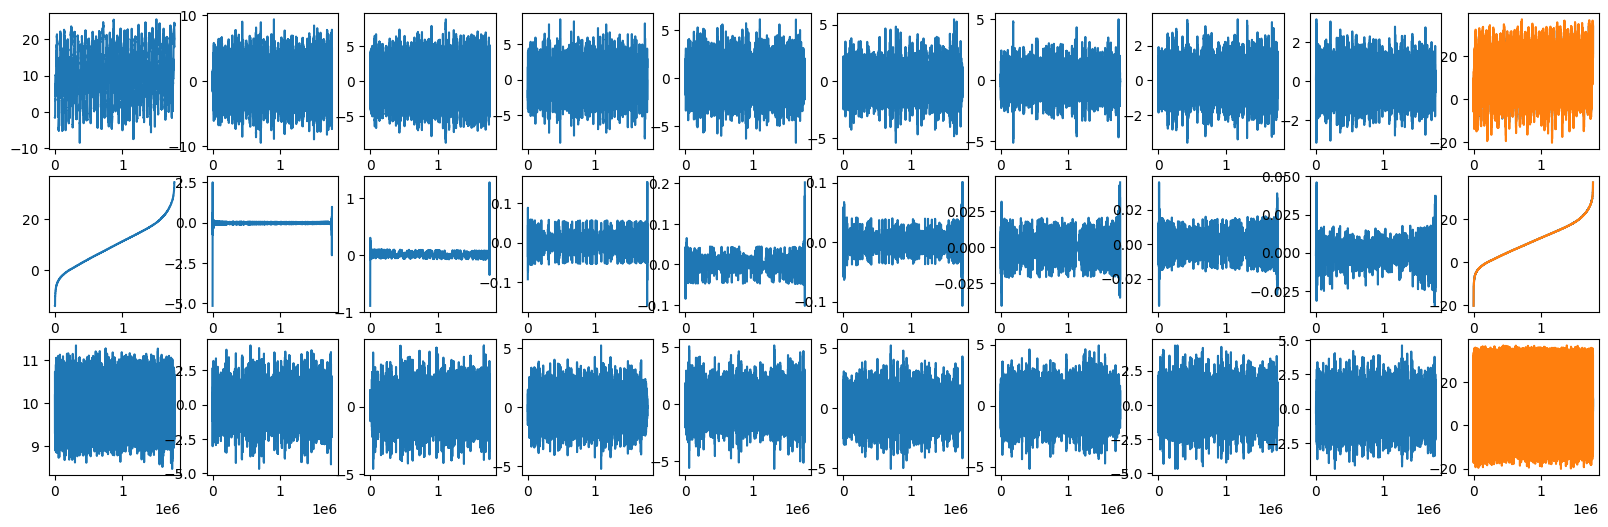

In [61]:
import matplotlib.pyplot as plt

# Plot
start = 0
stop = values.shape[0]
x = np.arange(start=start, stop=stop)

# Approximation
plt.figure(figsize=(20, 6))
for k in range(rank):
    ax1 = plt.subplot(3, rank + 1, k + 1)
    y1 = ranks[k, start:stop, 0]
    ax1.plot(x, y1)

    ax2 = plt.subplot(3, rank + 1, k + 1 + rank + 1)
    y2 = ranks_sorted[k, start:stop, 0]
    ax2.plot(x, y2)

    ax3 = plt.subplot(3, rank + 1, k + 1 + 2 * (rank + 1))
    y3 = ranks_shuffled[k, start:stop, 0]
    ax3.plot(x, y3)

# Original
ax1 = plt.subplot(3, rank + 1, rank + 1)
y1_approx = val_approx[start:stop, 0]
ax1.plot(x, y1_approx)
y1_orig = values[start:stop, 0]
ax1.plot(x, y1_orig)

ax2 = plt.subplot(3, rank + 1, rank + 1 + rank + 1)
y2_approx = val_approx_sorted[start:stop, 0]
ax2.plot(x, y2_approx)
y2_orig = values_sorted[start:stop, 0]
ax2.plot(x, y2_orig)

ax3 = plt.subplot(3, rank + 1, rank + 1 + 2 * (rank + 1))
y3_approx = val_approx_shuffled[start:stop, 0]
ax3.plot(x, y3_approx)
y3_orig = values_shuffled[start:stop, 0]
ax3.plot(x, y3_orig)
